# 4-top quark event data analysis

The following exercises aims to get you aquainted with some common data analysis tools which will come in handy to read in and manipulate raw data into a form where we can extract useful information out of it. This exercise relies on a real particle physics dataset which you can download at this [Google Drive](https://drive.google.com/file/d/14RfPABjncO3DXrwQkVsSVmu6IhR2CFpR/view).

# The problem

Currently a hot topic at the Large Hadron Collider is the search for the production of 4 of the heaviest quarks (the top quark) in a single event. These special events are called "4-top events". A signal for the production of these events has not been observed so far. The discovery of "4-top events" is interesting since it might be that more events are measured than expected. This could point to physics beyond the Standard Model of particle physics, since new physical processes could also generate events with 4 top quarks. The top quarks decay to other particles which are then measured in the detector surrounding the point where the quarks were originally produced.

<b>Background</b>

If you know the mass of a particle, most of the time you know <i>what that particle is</i>. However, there is no way to just build a single detector that gives you the mass. You need to be clever and make use of Special relativity, specifically <a href="http://en.wikipedia.org/wiki/Relativistic_mechanics">relativistic kinematics</a>.

To determine the mass ($m$) of a particle you need to know the 4-momenta of the particles ($\mathbf{P}$) that are detected after the collision: the energy ($E$), the momentum in the x direction ($p_x$), the momentum in the y direction ($p_y$), the momentum in the z direction ($p_z$).

$$\mathbf{P} = (E,p_x,p_y,p_z)$$


\begin{equation*} m = \sqrt{E^2-(p_x^2+p_y^2 + p_z^2)} \end{equation*}

# The LHC Dataset

The simulated training and validation data are provided in a one-line-per-event text format (CSV), where each line has variable length and contains 5 event-level quantities followed by low-level features for each object in the event. The format of CSV files are (in one line):

event ID; process ID; event weight; MET; METphi; obj1, E1, pt1, eta1, phi1; obj2, E2, pt2,
eta2, phi2; $\ldots$



- **obj** specifies the particles detected in the event (e.g. electron (e), photon (p), a so-called jet (j), a so-called b-jet (b) a muon (m) etc.). The + or - specifies the charge of the particle. 

- (**E**,**pt**,**eta**,**phi**) specify the 4-vector of the measured particle, i.e. the energy, transverse component of the momentum and the theta (given here in units of pseudorapidity) and phi angles.

- **event ID** is a serial integer to uniquely identify that particular event in the run.

- **event weight** is a real number to determine the likelihood of the process. This is a generator quantity and does not exist in real data. It should not be used for "training".

- **process ID** is a string referring to the process which generated the event. In real life events this is unknown on a event-by-event basis, but in simulated data sets (like the one we are providing you with) this information is accessible.

- **MET** and **METphi** entries are the magnitude and the azimuthal angle of the missing transverse energy vector of the event, respectively. "Missing" means that this momentum is taken away by undetected particles, e.g. neutrinos.
<br>

As an example, an event corresponding to the final state of the 
background $t\bar{t}+2j$ process with two $b$-jets and one jet reads as follows:
<br>
<br>
$$ \tiny
94;ttbar
;0.00167779;112288;1.74766;b,331927,147558,-1.44969,-1.76399;j,100406,85589,-0.568259,-1.17144;b,55808.8,54391.4,
-0.198215,1.726;j,72078.9,52432.5,-0.835736,1.57786; \ldots
;
$$
<br>
* <a href="http://en.wikipedia.org/wiki/Jet_(particle_physics)">Jets</a>  are a cone of hadrons that are produced from a collision.

In [1]:
# Common data analysis tool imports
import numpy as np               # Numpy. Optimized and highly performant multidimensional arrays in Python
from numpy import argmax    
import pandas as pd              # The Pandas package. Very useful tool for data analysis and data manipulation
import seaborn as sns            # Statistical plotting package, alternative to matplotlib
import matplotlib.pyplot as plt  # Standard Python plotting package

In [2]:
# Importing functionality from scikit-learn, a machine learning library
from sklearn.metrics import confusion_matrix, roc_curve    # Self-explanatory functionality

In [3]:
# Acccessing downloaded CSV files from Google Colab (this is specific for Google Colab, other solutions exist as well)
from google.colab import files
uploaded = files.upload()

Saving TrainingValidationData_320k_vs_80k_shuffle.csv to TrainingValidationData_320k_vs_80k_shuffle.csv


In [4]:
import io
df = pd.read_csv(io.BytesIO(uploaded['TrainingValidationData_320k_vs_80k_shuffle.csv']), header = None, sep='\n') 
# The above reads in the CSV data into a Pandas "Dataframe" object, a sort of in-memory "database", which can be queried like a database, filtered, etc.
# You can inspect, interact, and modify DataFrames in many ways ---> Read the docs! (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)

# As you can see, we specify "header = None", and "sep = '\n' " to reflect the fact that this file has an "unusual" shape (no header row, and rows have other delimiters like ";")

In [5]:
df = df[0].str.split(';|,', expand=True) # Because the data is in a CSV format, but has ";" separated content additionally... we want to expand this into a proper "database" for further manipulation
print(df.shape) # show the number of events (rows) and the number of data points (columns)

(400000, 101)


In [6]:
df.head(10)   # Show the first 10 rows of the data... There's a lot of "None"s in the later columns... Let's change that!

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,21,ttbar,1,19592.4,-0.0410686,b,431384,247371,-1.15222,1.84686,j,213946,209386,0.15921,-1.54733,j,437117,114355,-2.01385,2.49587,b,325344,102696,-1.81806,-2.61373,j,264381,94381.4,-1.68816,0.911486,j,102289,79279.5,0.742968,-0.824569,j,286397,47371,-2.48432,0.284316,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,21,ttbar,1,34361.5,-2.39277,b,104553,50546.8,1.34776,2.99585,b,92290,41017.6,1.44207,-1.93482,e+,157002,84815.6,1.22637,0.880097,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,21,ttbar,1,24356,-0.260029,j,255675,73086.1,1.92294,-1.81685,b,304656,69365.6,2.15966,2.62402,j,34450.9,31419,-0.422891,1.1691,m+,143384,73078.3,1.29477,-0.391141,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,21,ttbar,1,36565.7,-0.666041,b,131526,78025.7,1.10913,-3.06327,j,481649,65577.1,2.68213,0.276183,j,189547,58669.4,1.83809,-0.951545,b,54248.3,44391.9,-0.599836,2.1239,b,46417.5,34953.1,-0.773663,-2.8925,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,21,ttbar,1,8966.28,-1.89928,j,185195,79061,-1.49199,0.682821,j,57319.1,53416,-0.335488,-2.89574,j,156252,41927.5,-1.98904,-2.01592,j,26106,25063.6,-0.0169258,1.74293,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,21,ttbar,1,23917.4,1.69316,b,74494.2,52650,0.869359,1.74075,b,66159.8,52004.6,0.694358,-0.847169,j,407808,50008.8,2.7878,2.3065,j,162398,43717.4,1.98514,-0.648184,j,169970,38039.3,2.17656,-2.52978,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,21,ttbar,1,25571.3,-2.39031,j,158001,134569,0.565989,-0.573557,j,137536,98372.8,0.861471,2.93359,j,95527.2,93224.6,0.12508,-2.82266,b,60877.1,58178.3,-0.211073,-0.0354712,j,72025.9,48625.8,0.940629,0.292041,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,21,ttbar,1,19804.2,0.81136,j,145088,111437,0.736566,2.51313,j,168921,93965.8,-1.19046,-1.05389,j,88423.6,59281.9,-0.951829,-0.0881277,b,45176.7,43237.6,0.0439013,-0.176301,j,251543,38700.7,-2.55859,-3.05716,b,42004.9,33691.1,-0.67644,2.94843,,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,21,ttbar,1,62962.5,0.886331,b,166871,146545,-0.487993,-1.11008,j,92130.1,84659.9,0.318398,2.22891,j,153137,79068.5,1.26205,1.7495,j,79708.3,686

In [7]:
df = df.fillna(0) # Replace None values with 0's ---> Handy for type conversions later!
print("len(df.columns)", len(df.columns)) # You can access the list of "column names" with df.columns... As you can see above, they're currently just indexed (by numbers)
# print(df.column) <--- just to confirm the previous statement 

### Columns are fully separated (so you can access each via Dataframe indexing), so the number of columns reflects the number of data points there are ### 
### But let's compute the number of original "objects". Each object was originally grouped into 5's like [EventID, processID, evtweight, MET, METphi]  ### 
###  or [objID, E, px, py, pz]. So the following lines computes this, and one could use this information to add headers                                ###

n_obj = (len(df.columns) - 5) // 5       
print("n_obj =", n_obj)
df = df.drop(range(5 + 5 * n_obj, len(df.columns)), axis = 'columns') # Drop the empty column at the end

len(df.columns) 101
n_obj = 19


In [8]:
df.head(10) # Ok we're getting somewhere...

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,21,ttbar,1,19592.4,-0.0410686,b,431384,247371,-1.15222,1.84686,j,213946,209386,0.15921,-1.54733,j,437117,114355,-2.01385,2.49587,b,325344,102696,-1.81806,-2.61373,j,264381,94381.4,-1.68816,0.911486,j,102289,79279.5,0.742968,-0.824569,j,286397,47371,-2.48432,0.284316,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,21,ttbar,1,34361.5,-2.39277,b,104553,50546.8,1.34776,2.99585,b,92290,41017.6,1.44207,-1.93482,e+,157002,84815.6,1.22637,0.880097,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,21,ttbar,1,24356,-0.260029,j,255675,73086.1,1.92294,-1.81685,b,304656,69365.6,2.15966,2.62402,j,34450.9,31419,-0.422891,1.1691,m+,143384,73078.3,1.29477,-0.391141,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,21,ttbar,1,36565.7,-0.666041,b,131526,78025.7,1.10913,-3.06327,j,481649,65577.1,2.68213,0.276183,j,189547,58669.4,1.83809,-0.951545,b,54248.3,44391.9,-0.599836,2.1239,b,46417.5,34953.1,-0.773663,-2.8925,,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,21,ttbar,1,8966.28,-1.89928,j,185195,79061,-1.49199,0.682821,j,57319.1,53416,-0.335488,-2.89574,j,156252,41927.5,-1.98904,-2.01592,j,26106,25063.6,-0.0169258,1.74293,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,21,ttbar,1,23917.4,1.69316,b,74494.2,52650,0.869359,1.74075,b,66159.8,52004.6,0.694358,-0.847169,j,407808,50008.8,2.7878,2.3065,j,162398,43717.4,1.98514,-0.648184,j,169970,38039.3,2.17656,-2.52978,,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,21,ttbar,1,25571.3,-2.39031,j,158001,134569,0.565989,-0.573557,j,137536,98372.8,0.861471,2.93359,j,95527.2,93224.6,0.12508,-2.82266,b,60877.1,58178.3,-0.211073,-0.0354712,j,72025.9,48625.8,0.940629,0.292041,,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,21,ttbar,1,19804.2,0.81136,j,145088,111437,0.736566,2.51313,j,168921,93965.8,-1.19046,-1.05389,j,88423.6,59281.9,-0.951829,-0.0881277,b,45176.7,43237.6,0.0439013,-0.176301,j,251543,38700.7,-2.55859,-3.05716,b,42004.9,33691.1,-0.67644,2.94843,,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,21,ttbar,1,62962.5,0.886331,b,166871,146545,-0.487993,-1.11008,j,92130.1,84659.9,0.318398,2.22891,j,153137,79068.5,1.26205,1.7495,j,79708.3,68682.7,-0.553417,-2.32295,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,21,ttbar,1,27831.8,-2.6922,j,269994,138348,1.27167,-1.45395,j,878112,113719,2.73222,2.02191,j,107918,106497,0.137113,0.840852,j,212507,47149.7,2.18415,-2.63698,j,42072.4,39504.3,0.31538,2.80517,j,47230.5,36065.8,0.744566,-0.391823,j,246004,31563.8,2.74167,-1.51909,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# Make column headers so we can call them something meaningful
heads = ['EventID', 'ProcessID', 'evtweight', 'MET', 'METphi']
for i in range (n_obj):
  heads.append('obj%d' % i)
  heads.append('obj%d_E' % i)
  heads.append('obj%d_pt' % i)
  heads.append('obj%d_eta' % i)
  heads.append('obj%d_phi' % i)
df.columns = df.columns[:0].tolist() + heads # Set the DataFrame column names to headers

process_mapping = { 'ttbar': 0, '4top': 1} 
df['ProcessID'] = df['ProcessID'].map(process_mapping) # Map 'ttbar' to 0, and '4top' to 1

In [10]:
df.head(50) # Let's take a look at the final data-set (first 50 events) ...

,EventID,ProcessID,evtweight,MET,METphi,obj0,obj0_E,obj0_pt,obj0_eta,obj0_phi,obj1,obj1_E,obj1_pt,obj1_eta,obj1_phi,obj2,obj2_E,obj2_pt,obj2_eta,obj2_phi,obj3,obj3_E,obj3_pt,obj3_eta,obj3_phi,obj4,obj4_E,obj4_pt,obj4_eta,obj4_phi,obj5,obj5_E,obj5_pt,obj5_eta,obj5_phi,obj6,obj6_E,obj6_pt,obj6_eta,obj6_phi,...,obj11,obj11_E,obj11_pt,obj11_eta,obj11_phi,obj12,obj12_E,obj12_pt,obj12_eta,obj12_phi,obj13,obj13_E,obj13_pt,obj13_eta,obj13_phi,obj14,obj14_E,obj14_pt,obj14_eta,obj14_phi,obj15,obj15_E,obj15_pt,obj15_eta,obj15_phi,obj16,obj16_E,obj16_pt,obj16_eta,obj16_phi,obj17,obj17_E,obj17_pt,obj17_eta,obj17_phi,obj18,obj18_E,obj18_pt,obj18_eta,obj18_phi
0,21,0,1,19592.4,-0.0410686,b,431384,247371,-1.15222,1.84686,j,213946,209386,0.15921,-1.54733,j,437117,114355,-2.01385,2.49587,b,325344,102696,-1.81806,-2.61373,j,264381,94381.4,-1.68816,0.911486,j,102289,79279.5,0.742968,-0.824569,j,286397,47371,-2.48432,0.284316,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,21,0,1,34361.5,-2.39277,b,104553,50546.8,1.34776,2.99585,b,92290,41017.6,1.44207,-1.93482,e+,157002,84815.6,1.22637,0.880097,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,21,0,1,24356,-0.260029,j,255675,73086.1,1.92294,-1.81685,b,304656,69365.6,2.15966,2.62402,j,34450.9,31419,-0.422891,1.1691,m+,143384,73078.3,1.29477,-0.391141,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,21,0,1,36565.7,-0.666041,b,131526,78025.7,1.10913,-3.06327,j,481649,65577.1,2.68213,0.276183,j,189547,58669.4,1.83809,-0.951545,b,54248.3,44391.9,-0.599836,2.1239,b,46417.5,34953.1,-0.773663,-2.8925,,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,21,0,1,8966.28,-1.89928,j,185195,79061,-1.49199,0.682821,j,57319.1,53416,-0.335488,-2.89574,j,156252,41927.5,-1.98904,-2.01592,j,26106,25063.6,-0.0169258,1.74293,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,21,0,1,23917.4,1.69316,b,74494.2,52650,0.869359,1.74075,b,66159.8,52004.6,0.694358,-0.847169,j,407808,50008.8,2.7878,2.3065,j,162398,43717.4,1.98514,-0.648184,j,169970,38039.3,2.17656,-2.52978,,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,21,0,1,25571.3,-2.39031,j,158001,134569,0.565989,-0.573557,j,137536,98372.8,0.861471,2.93359,j,95527.2,93224.6,0.12508,-2.82266,b,60877.1,58178.3,-0.211073,-0.0354712,j,72025.9,48625.8,0.940629,0.292041,,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,21,0,1,19804.2,0.81136,j,145088,111437,0.736566,2.51313,j,168921,93965.8,-1.19046,-1.05389,j,88423.6,59281.9,-0.951829,-0.0881277,b,45176.7,43237.6,0.0439013,-0.176301,j,251543,38700.7,-2.55859,-3.05716,b,42004.9,33691.1,-0.67644,2.94843,,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,21,0,1,62962.5,0.886331,b,166871,146545,-0.487993,-1.11008,j,92130.1,84659.9,0.318398,2.22891,j,153137,79068.5,1.26205,1.7495,j,79708.3,68682.7,-0.553417,-2.32295,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,21,0,1,27831.8,-2.6922,j,269994,138348,1.27167,-1.45395,j,878112,113719,2.73222,2.02191,j,107918,106497,0.137113,0.840852,j,212507,47149.7,2.18415,-2.63698,j,42072.4,39504.3,0.31538,2.80517,j,47230.5,36065.8,0.744566,-0.391823,j,246004,31563.8,2.74167,-1.51909,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Now that we have the data-set in the form we want it in, here's the task for you. 

1. Plot a histogram showing the distribution of any kinematic variable, of 'obj1', for example the 'pt'.
2. Separate this into "signal" and "background" contributions by using the processID and the DataFrame filtering 
3. Plot the signal (4-top==1) and background (ttbar==0) distributions on the same histogram figure.
4. Make a cut, and evaluate the confusion matrix for this cut.
5. Make multiple cuts, and plot the ROC of the distribution.




In [11]:
########################################
################ Hints #################
########################################

# You may find it useful to make a DataFrame filter. Can you understand what's going on in the following line of code?
new_df = df[df["ProcessID"]==1]

# You may also find it useful to convert DataFrames to multidimensional numpy array for plotting
new_nparray = new_df["obj0_pt"].to_numpy().astype('float') # <----- Check the type of this array, and its individual elements, with "type()". See what you get!

# The solution

In [12]:
signal_df = df[df["ProcessID"]==1]
background_df = df[df["ProcessID"]==0]
signalnp = signal_df["obj0_pt"].to_numpy().astype('float')
backgroundnp = background_df["obj0_pt"].to_numpy().astype('float')
#print(signal_df["obj0_pt"].dtypes)

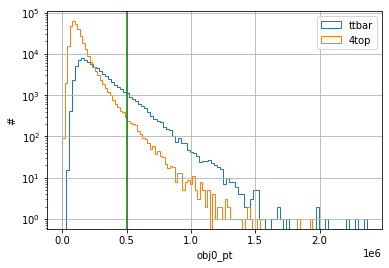

In [13]:
#signal_df.hist(column='obj0_pt')#, bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
plt.figure(1)
plt.hist(signalnp, 100, histtype="step", label="ttbar")
plt.hist(backgroundnp, 100, histtype="step", label="4top")
plt.axvline(500000,color='g')
plt.xlabel("obj0_pt")
plt.ylabel("#")
plt.grid()
plt.yscale("log")
plt.legend()

In [14]:
variables = df.columns[3:].tolist()
print(variables)
print("len(variables) =", len(variables))

['MET', 'METphi', 'obj0', 'obj0_E', 'obj0_pt', 'obj0_eta', 'obj0_phi', 'obj1', 'obj1_E', 'obj1_pt', 'obj1_eta', 'obj1_phi', 'obj2', 'obj2_E', 'obj2_pt', 'obj2_eta', 'obj2_phi', 'obj3', 'obj3_E', 'obj3_pt', 'obj3_eta', 'obj3_phi', 'obj4', 'obj4_E', 'obj4_pt', 'obj4_eta', 'obj4_phi', 'obj5', 'obj5_E', 'obj5_pt', 'obj5_eta', 'obj5_phi', 'obj6', 'obj6_E', 'obj6_pt', 'obj6_eta', 'obj6_phi', 'obj7', 'obj7_E', 'obj7_pt', 'obj7_eta', 'obj7_phi', 'obj8', 'obj8_E', 'obj8_pt', 'obj8_eta', 'obj8_phi', 'obj9', 'obj9_E', 'obj9_pt', 'obj9_eta', 'obj9_phi', 'obj10', 'obj10_E', 'obj10_pt', 'obj10_eta', 'obj10_phi', 'obj11', 'obj11_E', 'obj11_pt', 'obj11_eta', 'obj11_phi', 'obj12', 'obj12_E', 'obj12_pt', 'obj12_eta', 'obj12_phi', 'obj13', 'obj13_E', 'obj13_pt', 'obj13_eta', 'obj13_phi', 'obj14', 'obj14_E', 'obj14_pt', 'obj14_eta', 'obj14_phi', 'obj15', 'obj15_E', 'obj15_pt', 'obj15_eta', 'obj15_phi', 'obj16', 'obj16_E', 'obj16_pt', 'obj16_eta', 'obj16_phi', 'obj17', 'obj17_E', 'obj17_pt', 'obj17_eta', '

In [29]:
cut_val = 400000
signal_cut_filter = 1.0*(signalnp < cut_val)
backround_cut_filter = 1.0*(backgroundnp < cut_val)
signal_cut_filter[0:50]

array([1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.])

In [30]:
true_signal = signal_cut_filter.sum() # true positive (if 4-top is the signal, i.e. true 4-top) 
false_signal = backround_cut_filter.sum() # false positive (i.e. ttbar events classified as signal)
true_background = signal_cut_filter.shape[0] - true_signal # true negative (the ttbar that are greater than cut, i.e. are treated as background)
false_background = backround_cut_filter.shape[0] - false_signal # false negative (4-tops that are greater than cut)

In [93]:
confusion_mtx = np.array([[true_signal, false_signal], [false_background, true_background]])
print(confusion_mtx)

[[ 65600. 315700.]
 [  4300.  14400.]]


In [90]:
# Now, to compute the ROC curve, you have to repeat the above for multiple cut values
# and return the TPR and FPR
def compute_roc(signalnp, backgroundnp, low=0, high=400000, steps=1000):
  # feed in the signalnp and backgroundnp DataFrames, as well as the lower and upper bounds of the cuts
  cut_range = np.arange(low, high, (high-low)/steps) # make a range of values between low and high, with 1000 steps
  tpr = np.zeros(steps)
  fpr = np.zeros(steps) # just initializing these two arrays
  i = 0
  for cut in cut_range:
    signal_cut = 1.0*(signalnp < cut) 
    background_cut = 1.0*(backgroundnp < cut)

    true_signal = signal_cut.sum() # the true positives (i.e. signal < cut)
    true_background = signal_cut.shape[0] - true_signal # the true negatives (i.e. background > cut)
    false_signal = background_cut.sum() # the false positives (i.e. background < cut)
    false_background = background_cut.shape[0] - false_signal # the false negatives (i..e signal > cut)
    
    tpr[i] = true_signal/(true_signal + false_background)
    fpr[i] = false_signal/(true_background + false_signal)
    i+=1 # iterate the iterator

  return tpr, fpr, cut_range


In [91]:
tpr, fpr, cut_values = compute_roc(signalnp, backgroundnp, low=5000, high=5000000, steps=1000)
#print(tpr)
#print(fpr)
#print(cut_values)

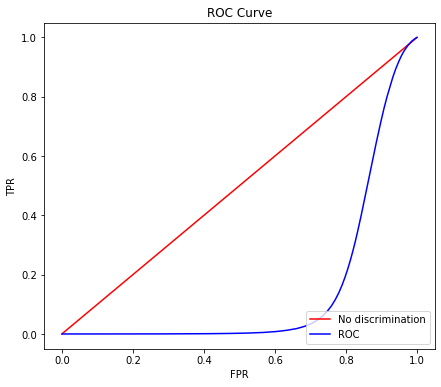

In [92]:
plt.figure(figsize=(7, 6))
plt.plot(tpr, tpr, color='red', label='No discrimination')
plt.plot(fpr, tpr, color='blue', label='ROC')
plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()